In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import naive_bayes
from datetime import timedelta
import re
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR

In [2]:
import collections

class Vocabulary(object):
    START_TOKEN = "<s>"
    END_TOKEN = "</s>"
    UNK_TOKEN = "<unk>"

    def __init__(self, tokens, size=None):
        self.unigram_counts = collections.Counter(tokens)
        self.num_unigrams = sum(self.unigram_counts.values())
        # leave space for "<s>", "</s>", and "<unk>"
        top_counts = self.unigram_counts.most_common(None if size is None else (size - 3))
        vocab = ([self.START_TOKEN, self.END_TOKEN, self.UNK_TOKEN] +
                 [w for w,c in top_counts])

        # Assign an id to each word, by frequency
        self.id_to_word = dict(enumerate(vocab))
        self.word_to_id = {v:k for k,v in self.id_to_word.items()}
        self.size = len(self.id_to_word)
        if size is not None:
            assert(self.size <= size)

        # For convenience
        self.wordset = set(self.word_to_id.keys())

        # Store special IDs
        self.START_ID = self.word_to_id[self.START_TOKEN]
        self.END_ID = self.word_to_id[self.END_TOKEN]
        self.UNK_ID = self.word_to_id[self.UNK_TOKEN]

    def words_to_ids(self, words):
        return [self.word_to_id.get(w, self.UNK_ID) for w in words]

    def ids_to_words(self, ids):
        return [self.id_to_word[i] for i in ids]

    def sentence_to_ids(self, words):
        return [self.START_ID] + self.words_to_ids(words) + [self.END_ID]

    def ordered_words(self):
        """Return a list of words, ordered by id."""
        return self.ids_to_words(range(self.size))


In [3]:
def clean(sentence):
    return sentence.lower().split()

# Load in Articles

In [4]:
df = pd.read_excel('all_season.xlsx')
df.head()

,date,name,news,team
0,2017-11-17,Bryan Bulaga,('The Green Bay Press-Gazette suggests the Pac...,Packers
1,2017-11-17,Philip Rivers,('Philip Rivers (concussion) has been cleared ...,Chargers
2,2017-11-17,Ezekiel Ansah,('The Detroit Free Press considers contract-ye...,Lions
3,2017-11-17,Ryan Grant,('Ryan Grant (concussion) is questionable for ...,Redskins
4,2017-11-17,Ronnie Stanley,('Ravens LT Ronnie Stanley (concussion) is lis...,Ravens


In [5]:
#Split sentences into words
df.iloc[0,2]

u"('The Green Bay Press-Gazette suggests the Packers could move on from RT Bryan Bulaga this offseason', '\\n             Bulaga is signed through 2019, but is coming off his second knee surgery in the last five years. It\u2019s not impossible Green Bay could cut ties, though Bulaga has been one of the better right tackles when healthy. Releasing Bulaga would leave $3.2 million in dead money.\\n        ')"

In [6]:
players = df.name.unique()

In [7]:
len(players)

1681

In [8]:
df.shape

(5665, 4)

In [9]:
df.head()

,date,name,news,team
0,2017-11-17,Bryan Bulaga,('The Green Bay Press-Gazette suggests the Pac...,Packers
1,2017-11-17,Philip Rivers,('Philip Rivers (concussion) has been cleared ...,Chargers
2,2017-11-17,Ezekiel Ansah,('The Detroit Free Press considers contract-ye...,Lions
3,2017-11-17,Ryan Grant,('Ryan Grant (concussion) is questionable for ...,Redskins
4,2017-11-17,Ronnie Stanley,('Ravens LT Ronnie Stanley (concussion) is lis...,Ravens


In [10]:
df.dtypes

date    datetime64[ns]
name            object
news            object
team            object
dtype: object

In [11]:
df.tail()

,date,name,news,team
5660,2016-10-25,Allen Hurns,"('Allen Hurns (neck, shoulder) was upgraded to...",Jaguars
5661,2016-10-25,Tajae Sharpe,('Tajae Sharpe (knee) returned to Titans pract...,Titans
5662,2016-10-25,Julius Thomas,"(""Julius Thomas (ankle) was held out of Tuesda...",Dolphins
5663,2016-10-25,DeMarcus Ware,('Broncos OLB DeMarcus Ware (arm) is expected ...,Free Agent
5664,2016-10-25,Brandon Marshall,('Broncos ILB Brandon Marshall is day to day w...,Broncos


In [12]:
cities = {
    'Bills':'Buffalo',
    'Dolphins':'Miami',
    'Patriots':'New England',
    'Jets':'New York',
    'Ravens':'Baltimore',
    'Bengals':'Cincinnati',
    'Browns':'Cleveland',
    'Steelers':'Pittsburgh',
    'Texans':'Houston',
    'Colts':'Indianapolis',
    'Jaguars':'Jacksonville',
    'Titans':'Tennessee',
    'Broncos':'Denver',
    'Chiefs':'Kansas City',
    'Chargers':'Los Angeles',
    'Raiders':'Oakland',
    'Cowboys':'Dallas',
    'Giants':'New York',
    'Eagles':'Philadelphia',
    'Redskins':'Washington',
    'Bears':'Chicago',
    'Lions':'Detroit',
    'Packers':'Green Bay',
    'Vikings':'Minnesota',
    'Falcons':'Atlanta',
    'Panthers':'Carolina',
    'Saints':'New Orleans',
    'Buccaneers':'Tampa Bay',
    'Cardinals':'Arizona',
    'Rams':'Los Angeles',
    '49ers':'San Francisco',
    'Seahawks':'Seattle'  
}

default_cities = defaultdict(str)
for city in cities.keys():
    default_cities[city] = cities[city]
    
print default_cities

defaultdict(<type 'str'>, {'Broncos': 'Denver', 'Vikings': 'Minnesota', 'Bears': 'Chicago', 'Falcons': 'Atlanta', 'Saints': 'New Orleans', 'Chargers': 'Los Angeles', 'Raiders': 'Oakland', 'Lions': 'Detroit', 'Eagles': 'Philadelphia', 'Browns': 'Cleveland', 'Steelers': 'Pittsburgh', 'Giants': 'New York', 'Buccaneers': 'Tampa Bay', 'Cardinals': 'Arizona', 'Bengals': 'Cincinnati', 'Chiefs': 'Kansas City', 'Dolphins': 'Miami', 'Jaguars': 'Jacksonville', 'Seahawks': 'Seattle', 'Jets': 'New York', 'Ravens': 'Baltimore', 'Colts': 'Indianapolis', 'Packers': 'Green Bay', 'Titans': 'Tennessee', 'Rams': 'Los Angeles', 'Bills': 'Buffalo', 'Texans': 'Houston', '49ers': 'San Francisco', 'Patriots': 'New England', 'Cowboys': 'Dallas', 'Panthers': 'Carolina', 'Redskins': 'Washington'})


In [13]:
regex = re.compile('[^a-zA-Z]')

def remove_names(row):
    parsed_sentence = str()
    for word in row['news'].split():
        word = regex.sub('',word)
        if word in row['name'].split():
            parsed_sentence = parsed_sentence+'<self> '
        elif word ==row['team']:
            parsed_sentence = parsed_sentence+'<own_team> '
        elif word in default_cities[row['team']].split():
            parsed_sentence = parsed_sentence+'<own_city> '
        else:
            parsed_sentence = parsed_sentence+word+' '
    return parsed_sentence

df['news_clean'] = df.apply(remove_names, axis = 1)
df['news_list'] = df['news_clean'].apply(lambda x: clean(x))
df.head()

,date,name,news,team,news_clean,news_list
0,2017-11-17,Bryan Bulaga,('The Green Bay Press-Gazette suggests the Pac...,Packers,The <own_city> <own_city> PressGazette suggest...,"[the, <own_city>, <own_city>, pressgazette, su..."
1,2017-11-17,Philip Rivers,('Philip Rivers (concussion) has been cleared ...,Chargers,<self> <self> concussion has been cleared to s...,"[<self>, <self>, concussion, has, been, cleare..."
2,2017-11-17,Ezekiel Ansah,('The Detroit Free Press considers contract-ye...,Lions,The <own_city> Free Press considers contractye...,"[the, <own_city>, free, press, considers, cont..."
3,2017-11-17,Ryan Grant,('Ryan Grant (concussion) is questionable for ...,Redskins,<self> <self> concussion is questionable for W...,"[<self>, <self>, concussion, is, questionable,..."
4,2017-11-17,Ronnie Stanley,('Ravens LT Ronnie Stanley (concussion) is lis...,Ravens,<own_team> LT <self> <self> concussion is list...,"[<own_team>, lt, <self>, <self>, concussion, i..."


In [14]:
#Match up scores with articles
scores = pd.read_csv('fantasy_points_data.csv', parse_dates= True)
scores.head()

,Player,Team,Position,Year,Week,Points
0,Drew Brees,NO,QB,2016,1,37.7
1,Andrew Luck,IND,QB,2016,1,37.4
2,Alex Smith,KC,QB,2016,1,33.7
3,Jameis Winston,TB,QB,2016,1,30.4
4,Matthew Stafford,DET,QB,2016,1,29.5


In [15]:
scores.dtypes

Player       object
Team         object
Position     object
Year          int64
Week          int64
Points      float64
dtype: object

In [16]:
scores.shape

(7161, 6)

In [17]:
scores['Week'].value_counts()

2     583
3     563
4     555
7     545
1     536
6     524
10    493
5     490
9     478
8     459
16    294
12    287
15    286
17    285
14    273
13    269
11    241
Name: Week, dtype: int64

In [18]:
scores['Year'].value_counts()

2016    4560
2017    2601
Name: Year, dtype: int64

In [19]:
weeks_in_2016 = scores[scores.Year==2016]['Week'].max()
weeks_in_2017 = scores[scores.Year==2017]['Week'].max()

In [20]:
avg_scores = scores.groupby(['Player','Year'], as_index=False)['Points'].sum()

def yearly_average(row):
    if row['Year']==2016:
        return row['Points']/weeks_in_2016
    elif row['Year']==2017:
        return row['Points']/weeks_in_2017


avg_scores['Avg_Points']= avg_scores.apply(yearly_average,axis=1)

avg_scores.sort_values('Avg_Points',ascending=False).head()

,Player,Year,Points,Avg_Points
8,Aaron Rodgers,2016,378.0,22.235294
701,Matt Ryan,2016,348.8,20.517647
346,Drew Brees,2016,338.5,19.911765
838,Russell Wilson,2017,198.7,19.870000
276,David Johnson,2016,333.3,19.605882


In [21]:
scores_combined = scores.merge(avg_scores, how='inner', left_on=['Player','Year'], right_on=['Player','Year'])
scores_combined['Diff_from_Avg']= scores_combined['Points_x']-scores_combined['Avg_Points']
scores_combined.head()

,Player,Team,Position,Year,Week,Points_x,Points_y,Avg_Points,Diff_from_Avg
0,Drew Brees,NO,QB,2016,1,37.7,338.5,19.911765,17.788235
1,Drew Brees,NO,QB,2016,2,14.5,338.5,19.911765,-5.411765
2,Drew Brees,NO,QB,2016,3,25.9,338.5,19.911765,5.988235
3,Drew Brees,NO,QB,2016,4,11.8,338.5,19.911765,-8.111765
4,Drew Brees,NO,QB,2016,6,32.6,338.5,19.911765,12.688235


In [22]:
start_of_season = {2016:pd.datetime.strptime('2016-09-08', '%Y-%m-%d'),
                  2017:pd.datetime.strptime('2017-09-08', '%Y-%m-%d')}

In [23]:
start_of_season2016 = pd.datetime.strptime('2016-09-08', '%Y-%m-%d')
start_of_season2017 = pd.datetime.strptime('2017-09-08', '%Y-%m-%d')

In [24]:
scores_combined['max_date'] = scores_combined.apply(lambda x: start_of_season[x['Year']] + timedelta(weeks = x['Week']), axis=1)
scores_combined['min_date'] = scores_combined.apply(lambda x: start_of_season[x['Year']] + timedelta(weeks = x['Week'] - 1), axis=1)

In [25]:
scores_combined.tail()

,Player,Team,Position,Year,Week,Points_x,Points_y,Avg_Points,Diff_from_Avg,max_date,min_date
7156,David Morgan,MIN,TE,2017,10,6.1,8.9,0.89,5.21,2017-11-17,2017-11-10
7157,Daniel Brown,CHI,TE,2017,8,0.9,3.2,0.32,0.58,2017-11-03,2017-10-27
7158,Daniel Brown,CHI,TE,2017,10,2.3,3.2,0.32,1.98,2017-11-17,2017-11-10
7159,MarQueis Gray,MIA,TE,2017,9,0.3,0.3,0.03,0.27,2017-11-10,2017-11-03
7160,Dwayne Allen,NE,TE,2017,10,7.1,7.1,0.71,6.39,2017-11-17,2017-11-10


In [26]:
combined = scores_combined.merge(df, how='inner', left_on='Player', right_on='name')

In [27]:
combined.shape

(48527, 17)

In [28]:
combined.iloc[50:100]

,Player,Team,Position,Year,Week,Points_x,Points_y,Avg_Points,Diff_from_Avg,max_date,min_date,date,name,news,team,news_clean,news_list
50,Drew Brees,NO,QB,2017,1,15.6,152.7,15.270000,0.330000,2017-09-15,2017-09-08,2016-11-17,Drew Brees,"(""Drew Brees completed 35-of-44 passes for 285...",Saints,<self> <self> completed of passes for yards t...,"[<self>, <self>, completed, of, passes, for, y..."
51,Drew Brees,NO,QB,2017,2,22.2,152.7,15.270000,6.930000,2017-09-22,2017-09-15,2017-07-27,Drew Brees,('Drew Brees fully intends to play out the fin...,Saints,<self> <self> fully intends to play out the fi...,"[<self>, <self>, fully, intends, to, play, out..."
52,Drew Brees,NO,QB,2017,2,22.2,152.7,15.270000,6.930000,2017-09-22,2017-09-15,2017-02-21,Drew Brees,"('In an interview on Sirius XM NFL Radio, Sain...",Saints,In an interview on Sirius XM NFL Radio <own_te...,"[in, an, interview, on, sirius, xm, nfl, radio..."
53,Drew Brees,NO,QB,2017,2,22.2,152.7,15.270000,6.930000,2017-09-22,2017-09-15,2016-11-17,Drew Brees,"(""Drew Brees completed 35-of-44 passes for 285...",Saints,<self> <self> completed of passes for yards t...,"[<self>, <self>, completed, of, passes, for, y..."
54,Drew Brees,NO,QB,2017,3,20.8,152.7,15.270000,5.530000,2017-09-29,2017-09-22,2017-07-27,Drew Brees,('Drew Brees fully intends to play out the fin...,Saints,<self> <self> fully intends to play out the fi...,"[<self>, <self>, fully, intends, to, play, out..."
55,Drew Brees,NO,QB,2017,3,20.8,152.7,15.270000,5.530000,2017-09-29,2017-09-22,2017-02-21,Drew Brees,"('In an interview on Sirius XM NFL Radio, Sain...",Saints,In an interview on Sirius XM NFL Radio <own_te...,"[in, an, interview, on, sirius, xm, nfl, radio..."
56,Drew Brees,NO,QB,2017,3,20.8,152.7,15.270000,5.530000,2017-09-29,2017-09-22,2016-11-17,Drew Brees,"(""Drew Brees completed 35-of-44 passes for 285...",Saints,<self> <self> completed of passes for yards t...,"[<self>, <self>, completed, of, passes, for, y..."
57,Drew Brees,NO,QB,2017,4,19.0,152.7,15.270000,3.730000,2017-10-06,2017-09-29,2017-07-27,Drew Brees,('Drew Brees fully intends to play out the fin...,Saints,<self> <self> fully intends to play out the fi...,"[<self>, <self>, fully, intends, to, play, out..."
58,Drew Brees,NO,QB,2017,4,19.0,152.7,15.270000,3.730000,2017-10-06,2017-09-29,2017-02-21,Drew Brees,"('In an interview on Sirius XM NFL Radio, Sain...",Saints,In an interview on Sirius XM NFL Radio <own_te...,"[in, an, interview, on, sirius, xm, nfl, radio..."
59,Drew Brees,NO,QB,2017,4,19.0,152.7,15.270000,3.730000,2017-10-06,2017-09-29,2016-11-17,Drew Brees,"(""Drew Brees completed 35-of-44 passes for 285...",Saints,<self> <self> completed of passes for yards t...,"[<self>, <self>, completed, of, passes, for, y..."


In [29]:
combined = combined[(combined['date'] <= combined['max_date']) & 
                    (combined['date'] >= combined['min_date'])]

In [30]:
combined.shape

(1137, 17)

In [31]:
combined.reset_index(inplace=True)

In [32]:
combined.to_excel('combined.xlsx')

In [33]:
#Normalize scores

In [34]:
#Split into train/test

In [35]:
token_feed = (word for news in combined['news_list'] for word in news)

vocab = Vocabulary(token_feed)

In [36]:
vocab.size

5695

In [37]:
for word, count in vocab.unigram_counts.most_common(10):
    print("\"%s\": %d" % (word, count))

"the": 4857
"<self>": 4491
"a": 2577
"in": 2288
"to": 1756
"for": 1592
"week": 1534
"n": 1309
"and": 1278
"of": 1273


In [38]:
encoded = pd.DataFrame([collections.Counter(vocab.words_to_ids(x)) for x in combined['news_list']], 
                       columns = range(vocab.size))

In [39]:
encoded.head()

,0,1,2,3,4,5,6,7,8,9,...,5685,5686,5687,5688,5689,5690,5691,5692,5693,5694
0,NaN,NaN,NaN,9.0,6.0,4.0,3.0,2.0,3.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,9.0,6.0,4.0,3.0,2.0,3.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,3.0,3.0,1.0,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,10.0,3.0,4.0,4.0,1.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,10.0,5.0,3.0,5.0,5.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
encoded.fillna(value= 0, inplace=True)

In [41]:
encoded.shape

(1137, 5695)

In [42]:
np.ndarray(vocab.size)

array([  1.29030374e-315,   1.91077090e-315,   0.00000000e+000, ...,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000])

In [43]:
X_train, X_test, y_train, y_test = train_test_split(encoded, combined['Diff_from_Avg'], test_size = 0.5)

In [44]:
SVM = LinearSVR()
SVM.fit(X_train, y_train)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [45]:
np.mean(np.square(SVM.predict(X_test) - np.array(y_test, dtype = np.float32)))**.5

6.6021043896641602

In [46]:
SVM.score(X_test, y_test)

-0.28170167470589025

In [47]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    #feature_names = feature_names)
    #return feature_names(top_coefficients)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names(top_coefficients), rotation=60, ha='right')
    plt.show()

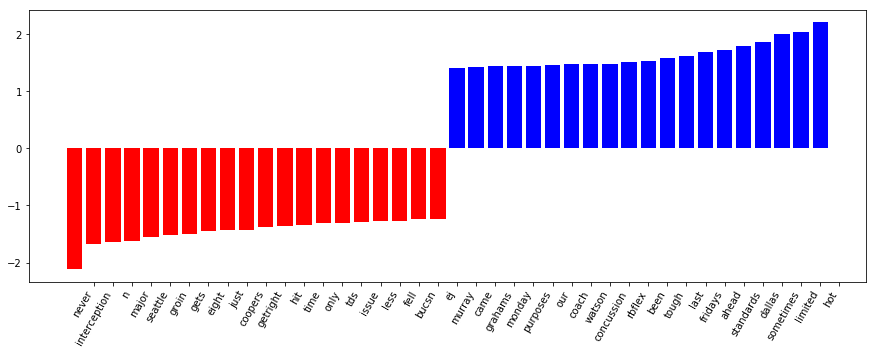

TypeError: 'NoneType' object is not iterable

In [48]:
vocab.ids_to_words(plot_coefficients(SVM, vocab.ids_to_words))